<img src="https://github.com/hernancontigiani/generative-image-demo/blob/main/banner.jpg?raw=true" width="800" align="center">

**Author:** Hernán Contigiani<br>
[Github](https://github.com/hernancontigiani/)<br>
[Linkedin](https://www.linkedin.com/in/hern%C3%A1n-contigiani-41260679/?locale=en_US)

# TFs saved models
This notebook was created was on the following notebook :\
[TFs Saved models](https://colab.research.google.com/github/deep-diver/keras-sd-serving/blob/main/notebooks/tfs_saved_models.ipynb)

## Introduction

In this notebook, we'll show how to serialize the three separate components of Stable Diffusion as SavedModels:

* Text encoder
* Diffusion model
* Decoder

The SavedModels are needed to be able to deploy using TensorFlow Serving and the TF deployment ecosystem in general.

For each of the above components, we'll first serialize them as a SavedModel resource. We'll then show how to load the SavedModels individually and run inference with them.

We'll conclude by collating all the SavedModels together and invoking them in succession so that users can provide text prompts as inputs and get generated images as outputs.

## Installation

In [ ]:
!pip install keras-cv==0.4.0 -q
!pip install -U tensorflow>=2.12 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 595.3/595.3 kB 34.9 MB/s eta 0:00:00


## Imports

In [ ]:
import time
import base64
import keras_cv
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
keras_cv.__version__

'0.4.0'

In [ ]:
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.decoder import Decoder

## Model instantiation

In [ ]:
MAX_PROMPT_LENGTH = 77
IMG_HEIGHT = 512
IMG_WIDTH = 512

text_encoder = TextEncoder(MAX_PROMPT_LENGTH)
diffusion_model = DiffusionModel(IMG_HEIGHT, IMG_WIDTH, MAX_PROMPT_LENGTH)
decoder = Decoder(IMG_HEIGHT, IMG_WIDTH)

198180272/198180272 [==============================] - 0s 0us/step


In [ ]:
# Download finetuned model from pokemon dataset
weights_path = tf.keras.utils.get_file(
    origin="https://huggingface.co/sayakpaul/kerascv_sd_pokemon_finetuned/resolve/main/ckpt_epochs_72_res_512_mp_True.h5"
)

# We just reload the weights of the fine-tuned diffusion model.
diffusion_model.load_weights(weights_path)

3439089408/3439089408 [==============================] - 197s 0us/step


## Diffusion model (that refines the latent)

The diffusion model takes several steps to refine the provided latent inputs. Say you have deployed the diffusion model as is as some endpoint. In its trivial form, you'd then have to call the deployed endpoint several times for the refinement step. The SavedModel serialized below wraps this entire logic so that you don't have to call the endpoint multiple times for refinement.

In [ ]:
from keras_cv.models.stable_diffusion.constants import _ALPHAS_CUMPROD

signature_dict = {
    "context": tf.TensorSpec(shape=[None, 77, 768], dtype=tf.float32, name="context"),
    "unconditional_context": tf.TensorSpec(
        shape=[None, 77, 768], dtype=tf.float32, name="unconditional_context"
    ),
    "num_steps": tf.TensorSpec(shape=[], dtype=tf.int32, name="num_steps"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def diffusion_model_exporter(model: tf.keras.Model):
    IMG_HEIGHT = 512
    IMG_WIDTH = 512
    MAX_PROMPT_LENGTH = 77
    _ALPHAS_CUMPROD_tf = tf.constant(_ALPHAS_CUMPROD)
    UNCONDITIONAL_GUIDANCE_SCALE = 7.5
    SEED = None

    @tf.function
    def get_timestep_embedding(timestep, batch_size, dim=320, max_period=10000):
        half = dim // 2
        log_max_preiod = tf.math.log(tf.cast(max_period, tf.float32))
        freqs = tf.math.exp(
            -log_max_preiod * tf.range(0, half, dtype=tf.float32) / half
        )
        args = tf.convert_to_tensor([timestep], dtype=tf.float32) * freqs
        embedding = tf.concat([tf.math.cos(args), tf.math.sin(args)], 0)
        embedding = tf.reshape(embedding, [1, -1])
        return tf.repeat(embedding, batch_size, axis=0)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        img_height = tf.cast(tf.math.round(IMG_HEIGHT / 128) * 128, tf.int32)
        img_width = tf.cast(tf.math.round(IMG_WIDTH / 128) * 128, tf.int32)

        batch_size = inputs["batch_size"]
        num_steps = inputs["num_steps"]

        context = inputs["context"]
        unconditional_context = inputs["unconditional_context"]

        latent = tf.random.normal((batch_size, img_height // 8, img_width // 8, 4))

        timesteps = tf.range(1, 1000, 1000 // num_steps)
        alphas = tf.map_fn(lambda t: _ALPHAS_CUMPROD_tf[t], timesteps, dtype=tf.float32)
        alphas_prev = tf.concat([[1.0], alphas[:-1]], 0)

        index = num_steps - 1
        latent_prev = None
        for timestep in timesteps[::-1]:
            latent_prev = latent
            t_emb = get_timestep_embedding(timestep, batch_size)
            unconditional_latent = model(
                [latent, t_emb, unconditional_context], training=False
            )
            latent = model([latent, t_emb, context], training=False)
            latent = unconditional_latent + UNCONDITIONAL_GUIDANCE_SCALE * (
                latent - unconditional_latent
            )
            a_t, a_prev = alphas[index], alphas_prev[index]
            pred_x0 = (latent_prev - tf.math.sqrt(1 - a_t) * latent) / tf.math.sqrt(a_t)
            latent = (
                latent * tf.math.sqrt(1.0 - a_prev) + tf.math.sqrt(a_prev) * pred_x0
            )
            index = index - 1

        return {"latent": latent}

    return serving_fn

In [ ]:
tf.saved_model.save(
    diffusion_model,
    "./diffusion_model/1/",
    signatures={"serving_default": diffusion_model_exporter(diffusion_model)},
)

Instructions for updating:
Use fn_output_signature instead


In [ ]:
from tensorflow.python.saved_model import tag_constants

saved_model_loaded = tf.saved_model.load(
    "./diffusion_model/1/", tags=[tag_constants.SERVING]
)
diffusion_predict_fn = saved_model_loaded.signatures["serving_default"]

In [ ]:
saved_model_loaded.signatures["serving_default"].structured_outputs

{'latent': TensorSpec(shape=(None, 64, 64, 4), dtype=tf.float32, name='latent')}

## Decoder (that generates images given the latents)

In [ ]:
signature_dict = {
    "latent": tf.TensorSpec(shape=[None, 64, 64, 4], dtype=tf.float32, name="latent"),
}


def decoder_exporter(model: tf.keras.Model):
    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        latent = inputs["latent"]
        decoded = model(latent, training=False)
        decoded = ((decoded + 1) / 2) * 255
        images = tf.clip_by_value(decoded, 0, 255)
        images = tf.cast(images, tf.uint8)
        return {"generated_images": images}

    return serving_fn

In [ ]:
tf.saved_model.save(
    decoder,
    "./decoder/1/",
    signatures={"serving_default": decoder_exporter(decoder)},
)

In [ ]:
saved_model_loaded = tf.saved_model.load("./decoder/1/", tags=[tag_constants.SERVING])
decoder_predict_fn = saved_model_loaded.signatures["serving_default"]

## Text encoder + tokenizer

The Tokenizer uses pure Python utilities and hence probably cannot be immediately serialized into a `tf.function`. The text encoder embeds the text prompt in the feature space. The text embeddings are a part of the inputs needed by the diffusion model.

In [ ]:
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.constants import _UNCONDITIONAL_TOKENS

In [ ]:
signature_dict = {
    "tokens": tf.TensorSpec(shape=[None, 77], dtype=tf.int32, name="tokens"),
    "batch_size": tf.TensorSpec(shape=[], dtype=tf.int32, name="batch_size"),
}


def text_encoder_exporter(model: tf.keras.Model):
    MAX_PROMPT_LENGTH = 77
    POS_IDS = tf.convert_to_tensor([list(range(MAX_PROMPT_LENGTH))], dtype=tf.int32)
    UNCONDITIONAL_TOKENS = tf.convert_to_tensor([_UNCONDITIONAL_TOKENS], dtype=tf.int32)

    @tf.function(input_signature=[signature_dict])
    def serving_fn(inputs):
        batch_size = inputs["batch_size"]

        # context
        encoded_text = model([inputs["tokens"], POS_IDS], training=False)
        encoded_text = tf.squeeze(encoded_text)

        if tf.rank(encoded_text) == 2:
            encoded_text = tf.repeat(
                tf.expand_dims(encoded_text, axis=0), batch_size, axis=0
            )

        # unconditional context
        unconditional_context = model([UNCONDITIONAL_TOKENS, POS_IDS], training=False)

        unconditional_context = tf.repeat(unconditional_context, batch_size, axis=0)
        return {"context": encoded_text, "unconditional_context": unconditional_context}

    return serving_fn

In [ ]:
tf.saved_model.save(
    text_encoder,
    "./text_encoder/1/",
    signatures={"serving_default": text_encoder_exporter(text_encoder)},
)

In [ ]:
saved_model_loaded = tf.saved_model.load(
    "./text_encoder/1/", tags=[tag_constants.SERVING]
)
text_encoder_predict_fn = saved_model_loaded.signatures["serving_default"]

## An end-to-end example

In [ ]:
tokenizer = SimpleTokenizer()
prompt = "A pokemon with red eyes"
tokens = tokenizer.encode(prompt)

In [ ]:
import matplotlib.pyplot as plt


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")

In [ ]:
import numpy as np
PADDING_TOKEN = 49407


def generate_images_from_text(
    text: str, batch_size: int = 4, num_steps: int = 25
) -> np.ndarray:
    batch_size = tf.constant(batch_size)
    num_steps = tf.constant(num_steps)

    tokens = tokenizer.encode(text)
    tokens = tokens + [PADDING_TOKEN] * (MAX_PROMPT_LENGTH - len(tokens))
    tokens = tf.convert_to_tensor([tokens], dtype=tf.int32)

    encoded_text = text_encoder_predict_fn(
        tokens=tokens,
        batch_size=batch_size,
    )

    latents = diffusion_predict_fn(
        batch_size=batch_size,
        context=encoded_text["context"],
        num_steps=num_steps,
        unconditional_context=encoded_text["unconditional_context"],
    )

    decoded_images = decoder_predict_fn(latent=latents["latent"])
    return decoded_images["generated_images"].numpy()

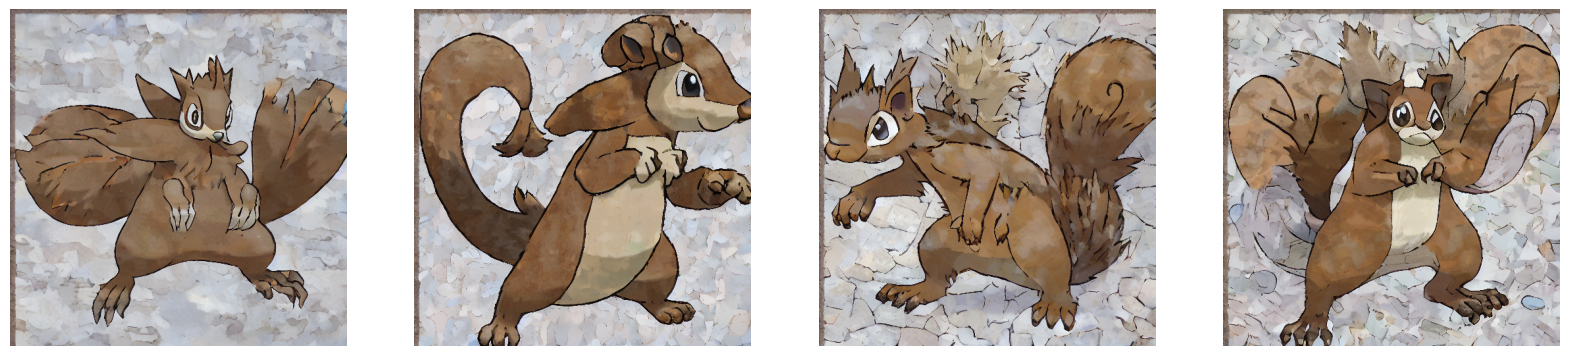

In [ ]:
plot_images(generate_images_from_text("An image of a squirrel"))

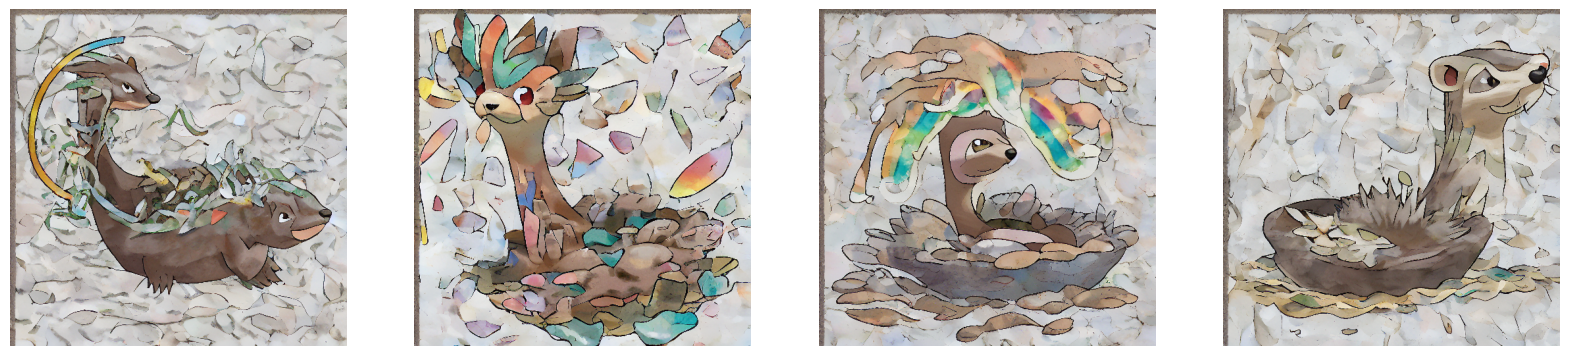

In [ ]:
plot_images(
    generate_images_from_text(
        "A cute otter in a rainbow whirlpool holding shells, watercolor"
    )
)

## Export models

In [ ]:
!zip -r text_encoder.zip text_encoder

  adding: text_encoder/ (stored 0%)
  adding: text_encoder/1/ (stored 0%)
  adding: text_encoder/1/fingerprint.pb (stored 0%)
  adding: text_encoder/1/assets/ (stored 0%)
  adding: text_encoder/1/variables/ (stored 0%)
  adding: text_encoder/1/variables/variables.data-00000-of-00001 (deflated 31%)
  adding: text_encoder/1/variables/variables.index (deflated 77%)
  adding: text_encoder/1/saved_model.pb (deflated 92%)


In [ ]:
!zip -r decoder.zip decoder

  adding: decoder/ (stored 0%)
  adding: decoder/1/ (stored 0%)
  adding: decoder/1/fingerprint.pb (stored 0%)
  adding: decoder/1/assets/ (stored 0%)
  adding: decoder/1/variables/ (stored 0%)
  adding: decoder/1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: decoder/1/variables/variables.index (deflated 76%)
  adding: decoder/1/saved_model.pb (deflated 93%)


In [ ]:
!zip -r diffusion_model.zip diffusion_model

  adding: diffusion_model/ (stored 0%)
  adding: diffusion_model/1/ (stored 0%)
  adding: diffusion_model/1/fingerprint.pb (stored 0%)
  adding: diffusion_model/1/assets/ (stored 0%)
  adding: diffusion_model/1/variables/ (stored 0%)
  adding: diffusion_model/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: diffusion_model/1/variables/variables.index (deflated 77%)
  adding: diffusion_model/1/saved_model.pb (deflated 93%)


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!cp diffusion_model.zip '/content/drive/MyDrive/tf_diffusion'

In [ ]:
!cp decoder.zip '/content/drive/MyDrive/tf_diffusion'

In [ ]:
!cp text_encoder.zip '/content/drive/MyDrive/tf_diffusion'